In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import numpy as np
import copy
import json
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import IPython
from IPython.display import Image as img
from IPython.display import display

from PIL import Image

import torch
import torch.nn as nn
import torchvision
from src.datamodules.datasets.dataset_modality import DatasetModality

In [4]:
from src.datamodules.datasets.emoreccom import EmoRecComDataset

In [5]:
emoreccom_path = "/home/ckoksal20/Documents/emorec"#"/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
dataset = EmoRecComDataset(emoreccom_path, modality=DatasetModality.Vision, train=True)

In [6]:
len(dataset)

6112

In [7]:
dataset.__getitem__(np.random.randint(dataset.__len__()))

(array([[[137, 193, 188],
         [146, 197, 193],
         [176, 218, 217],
         ...,
         [111, 180, 199],
         [115, 184, 203],
         [115, 184, 203]],
 
        [[167, 223, 218],
         [179, 230, 226],
         [213, 255, 254],
         ...,
         [111, 180, 199],
         [111, 180, 199],
         [111, 180, 199]],
 
        [[174, 232, 227],
         [164, 218, 213],
         [166, 210, 209],
         ...,
         [112, 181, 200],
         [110, 179, 198],
         [110, 179, 198]],
 
        ...,
 
        [[164, 245, 252],
         [156, 234, 241],
         [180, 249, 255],
         ...,
         [ 98, 176, 189],
         [103, 181, 194],
         [103, 181, 194]],
 
        [[111, 203, 208],
         [113, 201, 207],
         [139, 219, 226],
         ...,
         [ 99, 174, 188],
         [105, 180, 194],
         [105, 180, 194]],
 
        [[119, 218, 222],
         [122, 216, 221],
         [136, 220, 226],
         ...,
         [ 97, 172, 186],
  


### Dialogs:

### Narratives:




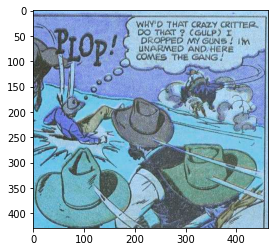

In [8]:
img, sizes, (labels, polarities), (narrative, dialog) = dataset.__getitem__(np.random.randint(dataset.__len__()))

for emotion, value, polarity in zip(dataset.emotion_list, labels, polarities):
    print(emotion, "\t\t" if len(emotion) <= 5 else "\t", "-->", value, "|", polarity)

print("\n### Dialogs:")
for d in dialog:
    print("-->", d)

print("\n### Narratives:")
for n in narrative:
    print("-->", n)

print("\n")

plt.imshow(img)



In [13]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [18]:
from mmdet.apis import init_detector, inference_detector

config_file = '../mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
# init a detector


model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
result = inference_detector(model, os.path.join(emoreccom_path,"public_train","train","436_31_2.jpg"))

load checkpoint from local path: ../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


/home/ckoksal20/anaconda3/envs/hydra/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [109]:
from tqdm import notebook
import random
from PIL import Image

In [20]:
person_detections = []
score_thr = 0.70
for path in tqdm(dataset.files):
    cur_path = os.path.join(emoreccom_path,"public_train","train",path)
    result = inference_detector(model, cur_path)
    bboxes = np.vstack(result)
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(result)
    ]
    labels = np.concatenate(labels)


    scores = bboxes[:, -1]
    inds = scores > score_thr
    bboxes = bboxes[inds, :4]
    labels = labels[inds]
    
    
    
    person_idx = [labels==0]
    
    bboxes = bboxes[person_idx]
    labels = labels[person_idx]
    
    
    annotation = {"path":path, "scores":scores[inds], "bboxes":bboxes, "labels":labels}
    person_detections.append(annotation)
    
    
    

  0%|                                                  | 0/6112 [00:00<?, ?it/s]/tmp/ipykernel_26455/2576077873.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bboxes = bboxes[person_idx]
/tmp/ipykernel_26455/2576077873.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  labels = labels[person_idx]
100%|███████████████████████████████████████| 6112/6112 [11:24<00:00,  8.93it/s]


In [35]:
len(person_detections)  

6112

In [101]:
for i, each in enumerate(person_detections):
    if len(each["bboxes"]) >= 6:
        print(each["path"])

994_58_1.jpg
63_42_5.jpg
1100_32_1.jpg
302_8_3.jpg
1079_31_5.jpg
1092_11_0.jpg
2199_16_0.jpg
553_25_0.jpg
1180_47_0.jpg
954_46_2.jpg
1809_29_1.jpg
2484_52_1.jpg
1096_23_7.jpg
2114_31_1.jpg
3234_12_5.jpg
141_46_0.jpg
54_28_5.jpg
3791_62_1.jpg
1802_36_8.jpg
1867_28_7.jpg
2544_5_0.jpg


In [94]:
count = 0
final_dict = {}
for i, each in enumerate(person_detections):
    if len(each["bboxes"]) >= 1:
        #print(len(each["bboxes"]))
        path = each["path"]
        random_idx = random.randint(0, len(each["bboxes"]) -1)
        #print("len bboxes : ", len(each["bboxes"]))
        #print("selected idx : ",random_idx)
        cur_bbox = each["bboxes"][random_idx][:4].tolist()
        #print(type(cur_bbox))
        final_dict[each["path"]] = cur_bbox
        
    elif len(each["bboxes"]) == 0:
        path = os.path.join(emoreccom_path,"public_train","train", each["path"])
        img = Image.open(path)
        width, height = img.width, img.height
    
        cur_bbox = [float(0), float(0), float(width), float(height)]
        final_dict[ each["path"]] = cur_bbox
        
        
    count += 1
print(count)

6112


In [96]:
import json
# Serializing json 

  
# Writing to sample.json
with open("selected_bbox.json", "w") as outfile:
    outfile.write(json_object)
    
json_object2 = json.load(open('../selected_bbox.json', 'r'))

In [87]:
final_dict

{'1184_6_2.jpg': array([  0.,   0., 419., 535.], dtype=float32),
 '722_61_2.jpg': array([ 34.127445, 273.59213 , 277.02875 , 641.2783  ], dtype=float32),
 '3524_19_7.jpg': array([180.30211, 160.7341 , 309.39255, 365.29288], dtype=float32),
 '1851_9_3.jpg': array([333.09232, 255.61327, 502.92615, 502.2752 ], dtype=float32),
 '3240_13_3.jpg': array([  0.,   0., 575., 598.], dtype=float32),
 '1190_7_1.jpg': array([   0.,    0.,  605., 1117.], dtype=float32),
 '1488_59_1.jpg': array([  0.,   0., 614., 611.], dtype=float32),
 '2803_20_5.jpg': array([ 46.527817, 259.82364 , 208.33139 , 547.9888  ], dtype=float32),
 '2155_13_6.jpg': array([  0.,   0., 487., 375.], dtype=float32),
 '3269_57_0.jpg': array([151.45615, 128.89513, 452.8001 , 486.12402], dtype=float32),
 '436_31_2.jpg': array([ 13.619452,  47.824005, 453.84113 , 575.7246  ], dtype=float32),
 '924_27_4.jpg': array([153.66986, 254.47545, 636.7528 , 828.81305], dtype=float32),
 '1518_41_4.jpg': array([ 15.199576, 114.80953 ,  84.2468 

In [62]:
person_detections[120]["bboxes"][0]

array([ 17.799314  ,  68.289375  , 279.75946   , 375.3396    ,
         0.89576554], dtype=float32)

In [106]:
from mmdet.apis import init_detector, inference_detector,show_result_pyplot

config_file = '../mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = '../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
# init a detector


model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
result = inference_detector(model, os.path.join(emoreccom_path,"public_train","train","1809_29_1.jpg"))

load checkpoint from local path: ../mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [103]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
# 1802_36_8.jpg

In [48]:
img = os.path.join(emoreccom_path,"public_train","train","1802_36_8.jpg")

In [107]:
img = os.path.join(emoreccom_path,"public_train","train","1809_29_1.jpg")

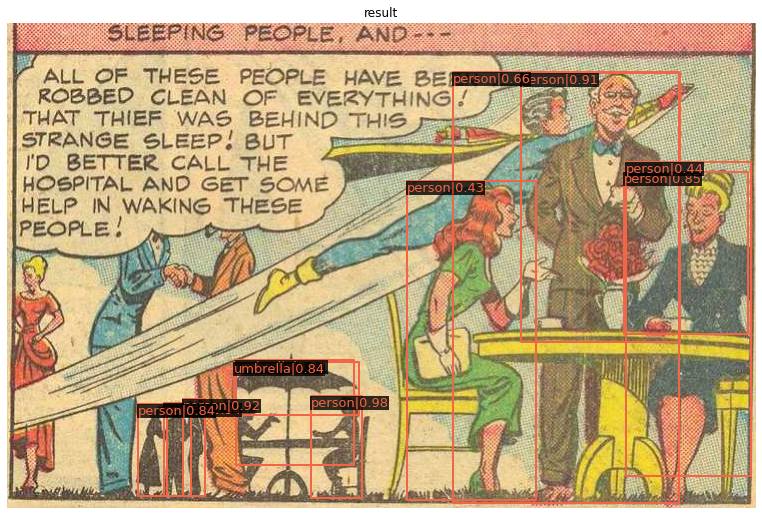

In [108]:
show_result_pyplot(model, img, result)